In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import unityneuro.render as umr

In [2]:
umr.setup(localhost = True, standalone = True)

(URN) connected to server
Login sent with ID: Dan


In [2]:
import atlaselectrophysiology.load_histology as hist
hist_paths = hist.download_histology_data(subject_ID, lab)

NameError: name 'subject_ID' is not defined

In [2]:
# Convert the TIFF files into numpy arrays
# import SimpleITK as sitk

In [45]:
# reader = sitk.ImageFileReader()
# reader.SetImageIO("TIFFImageIO")
# reader.SetFileName(str('./data/steven/STD_ds_NR_0020_GR.tif'))
# img = reader.Execute()

# new_img = sitk.PermuteAxes(img, [2, 1, 0])
# new_img = sitk.Flip(new_img, [True, False, False])
# new_img.SetSpacing([1, 1, 1])
# writer = sitk.ImageFileWriter()
# writer.SetImageIO("NrrdImageIO")
# writer.SetFileName(str('./data/steven/STD_ds_NR_0020_GR.nrrd'))
# writer.Execute(new_img)

In [10]:
import nrrd

# Load files are convert to a single volume
We want the track data to be in the red channel and the regular data to be in green

In [11]:
data_gr, meta = nrrd.read('./data/steven/STD_ds_NR_0020_GR.nrrd')
data_rd, meta = nrrd.read('./data/steven/STD_ds_NR_0020_RD.nrrd')

In [12]:
np.quantile(data_gr,0.99)

919.0

In [13]:
np.quantile(data_rd,0.99)

580.0

In [14]:
# define a function that will squish values into a smaller range of 100 values? save on data size
def quantizeImg(img):
    qs = np.quantile(img,np.linspace,0,1,11)
    img = img / qs[-1]

In [15]:
np.quantile(data_gr,np.linspace(0,1,21))

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+01, 1.3000e+01, 1.4000e+01, 1.6000e+01,
       1.8000e+01, 2.1000e+01, 1.4700e+02, 2.4700e+02, 3.0700e+02,
       3.6400e+02, 4.2300e+02, 4.8900e+02, 5.7100e+02, 6.9200e+02,
       1.9938e+04])

In [16]:
np.quantile(data_rd,np.linspace(0,1,11))

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0000e+00, 8.0000e+00,
       1.1000e+01, 8.5000e+01, 1.8700e+02, 2.6200e+02, 3.5600e+02,
       1.6537e+04])

In [17]:
data_gr_norm = data_gr / 1500 * 255
data_rd_norm = np.power(data_rd,1.3)
data_rd_norm[data_rd_norm<5000] = 0
data_rd_norm = data_rd_norm / 10000 * 255
data_rd_norm[data_rd_norm<=128] = 0
data_rd_norm[data_rd_norm>128] = 255

In [18]:
data = np.empty((528,320,456,4),dtype=np.uint8)
data[:,:,:,3] = 255
data[:,:,:,1] = data_gr_norm
data[:,:,:,0] = data_rd_norm

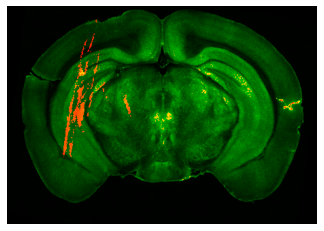

In [19]:
plt.axis('off')
plt.imshow(data[323,:,:,:])

(array([4.6299625e+07, 7.1163210e+06, 9.8294210e+06, 7.1854590e+06,
        3.9687880e+06, 1.7498640e+06, 6.0996200e+05, 1.8340100e+05,
        5.6721000e+04, 2.0199000e+04]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

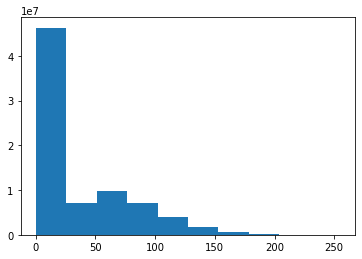

In [20]:
plt.hist(data_gr_norm[data_gr_norm<=255].flatten())

(array([76835276.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,   210484.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

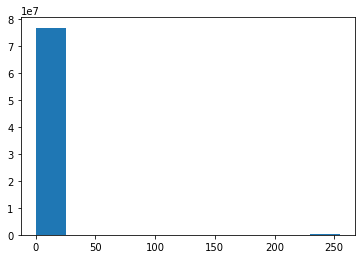

In [21]:
plt.hist(data_rd_norm[data_rd_norm<=255].flatten())

# Convert the histology data to a color-map-able dataset
What we'll do is re-scale the green values to some range of greens from black->bright green then we'll take the red channel and just check if it's >10 or so and if it is we'll assign it to red

In [37]:
out = np.empty((528,320,456),dtype=np.uint8)

In [5]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
def rgba_to_hex(rgba):
    return '#%02x%02x%02x%02x' % rgba

In [6]:
# First build a colormap for our colors
colormap = []
# First 100 values are greens
for i in np.arange(0,100):
    v = int(np.round(i*255/100))
    colormap.append(rgba_to_hex((0,v,0,64)))
# then red in 100th channel
colormap.append(rgb_to_hex((255,0,0)))

In [40]:
# Resample the volume and assign values, first we do the greens
# we want to resample the green data and bin values into 100 bins
# because there is more data at lower values, we can compress the space using the quantiles of the data to get better representation
green_qs = np.quantile(data_gr_norm[(data_gr_norm > 0) & (data_gr_norm<=255)].flatten(),np.linspace(0,1,100))

In [41]:
out[data_gr_norm>=255] = 99
out[data_gr_norm<green_qs[0]] = 255
for i in np.arange(1,len(green_qs)-1):
    out[(data_gr_norm > green_qs[i-1]) & (data_gr_norm <= green_qs[i])] = i

In [42]:
# Then red
out[data_rd_norm>=128] = 100

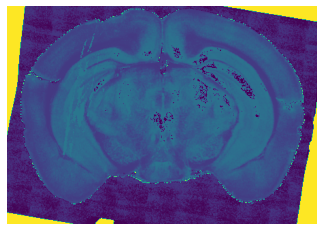

In [43]:
# Test the output
plt.axis('off')
plt.imshow(out[323,:,:])

In [44]:
data_gr_norm[323,:,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Send volume data to unity

In [51]:
np.save("temp.npy",out)

In [3]:
out = np.load("temp.npy")

In [7]:
umr.clear()
umr.create_volume("histology")
umr.set_volume_colormap("histology", colormap)
umr.set_volume_data("histology", out)
umr.set_volume_visibility("histology",True)